### Importing Necessary Libraries

In [1]:
import os
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, GlobalAvgPool1D, BatchNormalization, MultiHeadAttention, Layer, LayerNormalization, Concatenate, MaxPool1D
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [2]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [3]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

In [4]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [5]:
roi_info = np.load('./Data/ROI-Extractions/train/train_roi_viz.npy')

In [6]:
roi_info.shape

(16000, 100, 6)

## Data Preparation

In [7]:
BATCH_SIZE = 50
checkpnt_each = 100
assert checkpnt_each % BATCH_SIZE == 0
checkpnt_i = checkpnt_each // BATCH_SIZE
FEATURE_DIM = 2048
NUM_ROIS = 100
POS_ENC_ANGLE_DENO = 10000

In [8]:
roi_count = [np.sum([roi[-1]==1 for roi in doc]) for doc in roi_info] # RoIs per document Image

In [9]:
# fine_tune_data = list()
# for i in range(16000 // (BATCH_SIZE*checkpnt_i)):
#     k = 0
#     batch_data = np.load(f'./Data/ResNet-kP-train-precompute/train_data_precomp-{i+1}.npy')
#     batch_roi = roi_count[(i*(BATCH_SIZE*checkpnt_i)):((i+1)*(BATCH_SIZE*checkpnt_i))]
#     for j in range(BATCH_SIZE*checkpnt_i):
#         fine_tune_data.append(np.concatenate([batch_data[k:(k+batch_roi[j])], np.zeros((100-batch_roi[j], FEATURE_DIM))])[np.newaxis,:])
#         k += batch_roi[j]
# fine_tune_data = np.concatenate(fine_tune_data)
# fine_tune_data.shape

In [10]:
# np.save(f'./Data/ResNet-kP-train-precompute/whole_train_data_precomp.npy', fine_tune_data)

In [11]:
fine_tune_data = np.load(f'./Data/ResNet-kP-train-precompute/whole_train_data_precomp.npy')
fine_tune_data.shape

(16000, 100, 2048)

In [12]:
mask = np.zeros((*fine_tune_data.shape[:2], fine_tune_data.shape[1]))
k = 0
for num_roi in roi_count:
    mask[k,:num_roi,:num_roi] = 1
    k += 1

In [13]:
# fine_tune_data = np.squeeze(np.mean(fine_tune_data, axis=1, keepdims=True))
# fine_tune_data.shape

In [14]:
fine_tune_data_4P = np.load('./Data/ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_4P = np.reshape(fine_tune_data_4P, (16000, -1))
fine_tune_data_4P.shape

(16000, 10240)

In [15]:
# fine_tune_data = np.concatenate([fine_tune_data, fine_tune_data_4P], axis=-1)
# fine_tune_data.shape

In [16]:
# np.save(f'./Data/ResNet-kP-train-precompute/whole_train_data_precomp_roi_n_4p.npy', fine_tune_data)

In [17]:
# fine_tune_data = np.load(f'./Data/ResNet-kP-train-precompute/whole_train_data_precomp_roi_n_4p.npy')

In [18]:
# fine_tune_data.shape

In [19]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [20]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 100, 2048)

In [21]:
fine_tune_data_4P_train = fine_tune_data_4P[list(train_labels['id'])]
fine_tune_data_4P_train.shape

(15200, 10240)

In [22]:
fine_tune_mask_train = mask[list(train_labels['id'])]
fine_tune_mask_train.shape

(15200, 100, 100)

In [23]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [24]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 100, 2048)

In [25]:
fine_tune_data_4P_test = fine_tune_data_4P[list(test_labels['id'])]
fine_tune_data_4P_test.shape

(800, 10240)

In [26]:
fine_tune_mask_test = mask[list(test_labels['id'])]
fine_tune_mask_test.shape

(800, 100, 100)

In [27]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

### Validation Data

In [28]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [29]:
roi_info_validation = np.load('./Data/ROI-Extractions/validation/validation_roi_viz.npy')
roi_info_validation.shape

(900, 100, 6)

In [30]:
roi_count_validation = [np.sum([roi[-1]==1 for roi in doc]) for doc in roi_info_validation] # RoIs per document Image

In [31]:
# fine_tune_data_validation = list()
# for i in range(900 // (BATCH_SIZE*checkpnt_i)):
#     k = 0
#     batch_data = np.load(f'./Data/ResNet-kP-validation-precompute/validation_data_precomp-{i+1}.npy')
#     batch_roi = roi_count_validation[(i*(BATCH_SIZE*checkpnt_i)):((i+1)*(BATCH_SIZE*checkpnt_i))]
#     for j in range(BATCH_SIZE*checkpnt_i):
#         fine_tune_data_validation.append(np.concatenate([batch_data[k:(k+batch_roi[j])], np.zeros((100-batch_roi[j], 2048))])[np.newaxis,:])
#         k += batch_roi[j]
# fine_tune_data_validation = np.concatenate(fine_tune_data_validation)
# fine_tune_data_validation.shape

In [32]:
# np.save(f'./Data/ResNet-kP-validation-precompute/whole_validation_data_precomp.npy', fine_tune_data_validation)

In [33]:
fine_tune_data_validation = np.load(f'./Data/ResNet-kP-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation.shape

(900, 100, 2048)

In [34]:
mask_validation = np.zeros((*fine_tune_data_validation.shape[:2], fine_tune_data_validation.shape[1]))
k = 0
for num_roi in roi_count_validation:
    mask_validation[k,:num_roi,:num_roi] = 1
    k += 1

In [35]:
mask_validation.shape

(900, 100, 100)

In [36]:
# fine_tune_data_validation = np.squeeze(np.mean(fine_tune_data_validation, axis=1, keepdims=True))
# fine_tune_data_validation.shape

In [37]:
fine_tune_data_4P_validation = np.load('./Data/ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_4P_validation = np.reshape(fine_tune_data_4P_validation, (900, -1))
fine_tune_data_4P_validation.shape

(900, 10240)

In [38]:
# fine_tune_data_validation = np.concatenate([fine_tune_data_validation, fine_tune_data_4P_validation], axis=-1)
# fine_tune_data_validation.shape

In [39]:
# np.save(f'./Data/ResNet-kP-validation-precompute/whole_validation_data_precomp_roi_n_4p.npy', fine_tune_data_validation)

In [40]:
# fine_tune_data_validation = np.load(f'./Data/ResNet-kP-validation-precompute/whole_validation_data_precomp_roi_n_4p.npy')

In [41]:
# fine_tune_data_validation.shape

## Fine-Tuning Models

The fine-tuning part of our model.

In [42]:
def pos_enc(max_len=NUM_ROIS, d_model=FEATURE_DIM):
    # returns the positional encoding matrix which needs to be added to the embedding matrix
    angles = np.arange(max_len)[:, np.newaxis] / np.power(POS_ENC_ANGLE_DENO, 2*(np.arange(d_model)[np.newaxis, :]//2/np.float32(d_model)))
    pos_encode = np.zeros((max_len, d_model))
    pos_encode[:, 0::2] = np.sin(angles[:, 0::2])
    pos_encode[:, 1::2] = np.cos(angles[:, 1::2])
    return tf.cast(pos_encode[np.newaxis, :], dtype=tf.float32)

In [43]:
pos_enc().shape

Metal device set to: Apple M1 Max


2022-10-09 03:01:34.463502: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-09 03:01:34.463703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


TensorShape([1, 100, 2048])

In [44]:
class TransformerBlock(Layer):
    # Embed Dimension is FEATURE_DIM
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, kernel_regularizer=l2(5e-5))
        self.ffn = keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, mask, training):
        attn_output = self.att(inputs, inputs, inputs, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [45]:
NUM_HEADS = 8
FF_DIM = FEATURE_DIM // 8
def ftmodel():
    inputs = Input(shape=(5*FEATURE_DIM))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)
    
    inputs_roi = Input(shape=(100, FEATURE_DIM))
    inputs_roi_mask = Input(shape=(100, 100))
    y = inputs_roi + pos_enc()
    y = MaxPool1D(strides=4, data_format='channels_first')(inputs_roi)
    y = TransformerBlock(y.shape[-1], NUM_HEADS, FF_DIM)(y, inputs_roi_mask)
    y = GlobalAvgPool1D()(y)
    
    x = Concatenate()([x, y])
    
    top_dropout_rate = 0.3
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model([inputs, inputs_roi, inputs_roi_mask], outputs, name='ResNet-FineTune')
    return model1

In [46]:
model1 = ftmodel()
model1.summary()

Model: "ResNet-FineTune"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 2048)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10240)]      0           []                               
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 100, 512)     0           ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 100, 100)]   0           []                               
                                                                                    

### Model Training

The fine-tuning will be done on the ResNet's $2048D$ representation vectors for $5$ pieces of the image and the averaged ROI representation vectors.

In [47]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [48]:
EPOCHS = 20
checkpoint_filepaths = ['./Models/ResNet-kP-ViT/auto-ResNet-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [49]:
history = model1.fit([fine_tune_data_4P_train, fine_tune_data_train, fine_tune_mask_train], fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=([fine_tune_data_4P_test, fine_tune_data_test, fine_tune_mask_test], fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
# history = model1.fit(fine_tune_data, fine_tune_labels, epochs=EPOCHS, batch_size=1600, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/ResNet-kP-ViT/resnet-kp-model-weights")
model1.load_weights('./Models/ResNet-kP-ViT/resnet-kp-model-weights')

Epoch 1/20


2022-10-09 03:01:50.131138: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-09 03:01:50.774764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 1.8380 - accuracy: 0.5124 

2022-10-09 03:05:34.608255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 230s 12s/step - loss: 1.8380 - accuracy: 0.5124 - val_loss: 2.1738 - val_accuracy: 0.3750
Epoch 2/20
19/19 [==============================] - 227s 12s/step - loss: 1.0862 - accuracy: 0.7010 - val_loss: 1.9928 - val_accuracy: 0.4075
Epoch 3/20
19/19 [==============================] - 232s 12s/step - loss: 0.8415 - accuracy: 0.7720 - val_loss: 1.8364 - val_accuracy: 0.4887
Epoch 4/20
19/19 [==============================] - 230s 12s/step - loss: 0.6833 - accuracy: 0.8207 - val_loss: 1.7835 - val_accuracy: 0.5238
Epoch 5/20
19/19 [==============================] - 231s 12s/step - loss: 0.5664 - accuracy: 0.8602 - val_loss: 1.7858 - val_accuracy: 0.5525
Epoch 6/20
19/19 [==============================] - 230s 12s/step - loss: 0.4749 - accuracy: 0.8895 - val_loss: 1.7985 - val_accuracy: 0.5400
Epoch 7/20
19/19 [==============================] - 230s 12s/step - loss: 0.3989 - accuracy: 0.9105 - val_loss: 1.8214 - val_accuracy: 0.5587
Epoch 8/20
19/19 

In [50]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

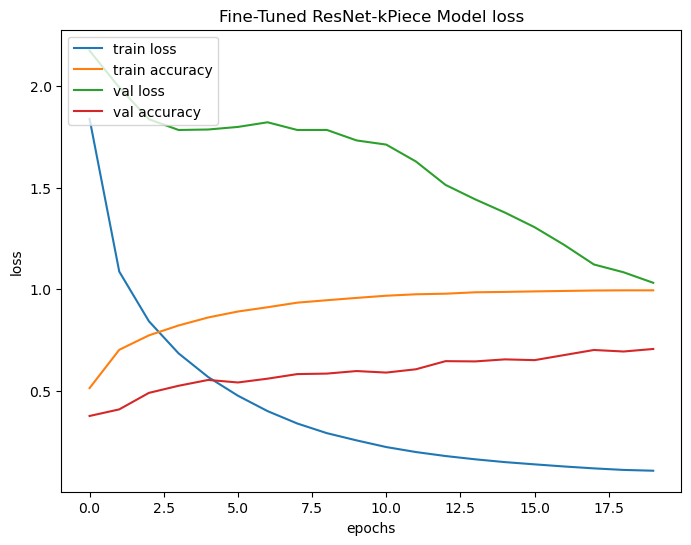

In [51]:
plot_train_loss(history, 'Fine-Tuned ResNet-kPiece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [63]:
train_preds = model1.predict(fine_tune_data_train)

 56/475 [==>...........................] - ETA: 1s

2022-10-08 15:57:13.418176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 2s 4ms/step


In [64]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [65]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [66]:
np.sum(train_pred_labels == train_labels['label'])

15193

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [67]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
3597,3781,./Data/train/train/3781.tif,0
4633,4876,./Data/train/train/4876.tif,12
5298,5578,./Data/train/train/5578.tif,11
7417,7807,./Data/train/train/7807.tif,11
12255,12896,./Data/train/train/12896.tif,9
12916,13599,./Data/train/train/13599.tif,5
14569,15333,./Data/train/train/15333.tif,7


In [68]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,1.000000,0.998978,0.999488,978
1,0.995694,1.000000,0.997843,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,0.998960,0.999480,962
6,1.000000,1.000000,1.000000,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


#### On Train-Test Data

In [69]:
test_preds = model1.predict(fine_tune_data_test)

25/25 [==============================] - 0s 3ms/step


In [70]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [71]:
test_pred_labels

array([11,  8,  6, 11, 14,  9, 13,  4, 14,  1,  6, 15, 10, 14,  1, 11,  0,
        9,  6,  1,  8, 14,  3, 12,  6,  0,  3,  3,  3,  3, 11,  1,  6,  2,
        1,  8,  4,  5,  1,  9,  6, 12, 14,  2,  5, 14,  3,  0, 13,  4,  0,
       10, 12,  0, 11, 14, 15,  6,  9,  2, 15, 13,  2, 11,  7, 12,  8,  0,
        6,  3,  4,  4, 12,  0,  8,  6,  7,  0, 12, 11, 11,  0, 12, 12,  9,
        8,  1, 13,  0, 13, 10, 11,  4, 10,  1,  7, 11,  8, 13, 10,  3, 11,
        5,  9,  7, 14,  8,  2,  1,  8,  7,  5,  9,  4, 12, 14, 12, 10, 11,
        6, 13,  1,  0, 12, 13,  5, 10,  8,  0, 11,  3, 11,  6,  1,  6,  9,
       14, 10,  7, 14, 10,  8,  4, 12,  8,  5,  8,  9,  2, 13, 15,  5,  4,
       14,  4,  9,  4, 14,  7,  7,  8,  4,  4, 12, 13,  8, 15,  3,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 11, 13, 11,  6, 13,  4,
       14, 11,  7, 15,  0,  3,  0, 10, 13,  5, 10, 11, 11, 15,  1,  9,  1,
        9,  5, 13, 12, 12,  1,  4,  8, 11,  6, 13,  5,  4, 12,  8,  0,  9,
       13, 15,  0,  7, 10

In [72]:
np.sum(test_pred_labels == test_labels['label'])

629

In [73]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
3,41,./Data/train/train/41.tif,1
7,100,./Data/train/train/100.tif,10
12,179,./Data/train/train/179.tif,7
19,372,./Data/train/train/372.tif,13
20,378,./Data/train/train/378.tif,12
...,...,...,...
776,15528,./Data/train/train/15528.tif,5
779,15568,./Data/train/train/15568.tif,9
780,15571,./Data/train/train/15571.tif,14
782,15582,./Data/train/train/15582.tif,3


In [74]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.741379,0.796296,0.767857,54
1,0.551724,0.727273,0.627451,44
2,0.897436,0.813953,0.853659,43
3,0.840000,0.913043,0.875000,46
4,0.850000,0.944444,0.894737,36
5,0.704545,0.620000,0.659574,50
6,0.851064,0.869565,0.860215,46
7,0.800000,0.769231,0.784314,52
8,0.841270,0.981481,0.905983,54
9,0.869565,0.851064,0.860215,47


In [75]:
np.mean(fscore)

0.787085876889608

#### On Validation Data

Generating Predictions for the Validation Set

In [76]:
valid_preds = model1.predict(fine_tune_data_validation)

29/29 [==============================] - 0s 4ms/step


2022-10-08 15:57:39.999356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [77]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

In [78]:
valid_pred_labels

array([ 4,  6,  4,  8,  3,  8, 11, 11,  2,  4,  0, 15, 14, 12, 13,  4, 11,
        1,  0,  5, 14,  9, 13,  6,  1,  2,  7,  3,  8,  1, 15, 14,  8, 10,
       14,  6, 11,  8,  6, 10,  4,  7, 12,  3,  2, 10,  3,  2,  6,  2, 10,
        0, 10,  7, 13,  9,  2,  3,  1, 10,  2, 13,  4,  5, 12,  8,  9,  7,
        8,  4,  5,  5,  4,  8,  4,  6,  4, 15, 11,  0,  9, 15, 13,  8,  7,
       12, 11, 10, 12, 10, 12,  0,  1, 12,  3,  4, 10, 10,  7,  4,  6, 11,
        1, 12,  7, 13, 15,  9, 10,  1,  7,  7, 11, 14,  2,  4,  1, 14,  1,
       11, 12,  5,  3,  6,  1,  1,  0,  9,  4, 12,  8,  1,  0,  9, 10,  3,
        0, 11, 13,  5,  6,  7,  2,  3,  0,  9,  9, 15,  1, 14, 10,  1, 13,
        8, 12, 10,  0,  7,  5, 14,  3,  1,  2, 10,  7,  5,  4,  4,  7,  9,
       12, 11,  4,  7,  4,  0, 11, 12,  0,  8,  9, 11,  3,  2,  3,  3,  7,
        8, 11,  2,  9, 12,  6,  2,  4,  9,  2,  9,  8,  7,  1,  3,  1,  0,
       15,  1,  4,  3,  4,  4, 11,  6,  6,  7,  4,  4, 13,  3, 10, 14,  1,
        6,  0,  8, 12,  2

### Submission

For Kaggle Submission

In [79]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,4
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,13
896,18697,12
897,18698,8
898,18699,5


In [80]:
submission_data.to_csv('./Submissions/submission-resnet-kPiece.csv', index=False)